In [1]:
import sys
print(sys.version)
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import itertools
import gfapy
import time
from smithnormalform import matrix, snfproblem, z


3.8.8 (default, Apr 13 2021, 12:59:45) 
[Clang 10.0.0 ]


In [2]:
def flowMultipleDecomposition(data,K):
    
   
    # calculate the minimal flow decomposition based on such graph
    V = data['vertices']
    E = data['edges']
    f = data['flows']
    W = 1e5
    S = {str(min(map(int,V)))}
    D = {str(max(map(int,V)))}
    
    print()

    
    # import library
    from docplex.mp.model import Model

    # model name
    Flow = Model(name = 'Flow Decomposition')

    # define variables
    x = {(i,j,k): Flow.binary_var(name="x_{0}_{1}_{2}".format(i,j,k)) for (i,j) in E for k in range(0,K)}
    w = {(k): Flow.integer_var(name="w_{0}".format(k)) for k in range(0,K)}
    z = {(i,j,k): Flow.integer_var(name="z_{0}_{1}_{2}".format(i,j,k)) for (i,j) in E for k in range(0,K)}

    # flow conservation
    for k in range(0,K):
        for i in V:
            if i in S:
                Flow.add_constraint(sum(x[i,j,k] for j in V if i!=j and(i,j) in E) - sum(x[j,i,k] for j in V if i!=j and (j,i) in E) == 1)  
            if i in D:
                Flow.add_constraint(sum(x[i,j,k] for j in V if i!=j and (i,j) in E) - sum(x[j,i,k] for j in V if i!=j and (j,i) in E) == -1)
            if i not in S and i not in D:
                Flow.add_constraint(sum(x[i,j,k] for j in V if i!=j and (i,j) in E) - sum(x[j,i,k] for j in V if i!=j and (j,i) in E) == 0)
    
    # flow balance
    for (i,j) in E:
        Flow.add_constraint(f[i,j] == sum(z[i,j,k] for k in range(0,K)))
        
    
    # linearization
    for (i,j) in E:
        for k in range(0,K):
            Flow.add_constraint(z[i,j,k] <= W*x[i,j,k])
            Flow.add_constraint(w[k] - (1 - x[i,j,k])*W <= z[i,j,k])
            Flow.add_constraint(z[i,j,k] <= w[k])
            #Flow.add_constraint(z[i,j,k] >= 0)
    
    # objective function
    Flow.minimize(1)
    
    Flow.parameters.threads = 8
    Flow.parameters.mip.display = 0
    Flow.parameters.timelimit = 60

    
    Flow.print_information()
    Flow.export_as_lp("test.txt")
    timezero = time.time()
    sol = Flow.solve(log_output=False)
    data['runtime'] = time.time() - timezero
    print('status',Flow.solve_details.status)

    if Flow.solve_details.status == 'integer infeasible' or Flow.solve_details.status == 'time limit exceeded, no integer solution':
        data['messsage'] = "infeasible"
        return data

    elif Flow.solve_details.status == 'time limit exceeded':
        print('time limit')

    #print('FD obj value',Flow.objective_value)    
    #print('FD best bound (LB)',Flow.solve_details.best_bound)    
    #print('FD time',Flow.solve_details.time)

    # calculate averages
    x_sol = {(i,j,k):Flow.solution.get_value(x[(i,j,k)]) for (i,j) in E for k in range(0,K)}
    w_sol = {(k):Flow.solution.get_value(w[(k)]) for (k) in range(0,K)}
    paths =[list() for i in range(0,K)]
    for k in range(0,K):
        for (i,j) in E:
            if x_sol[i,j,k] == 1:
                paths[k].append((i,j))
               
    data['weights'] = w_sol
    data['solution'] = paths
    data['message'] = 'solved'
    
    
    return data;
    

In [3]:
def FD_Algorithm(data):
    
    listOfEdges = data['edges']
    solutionMap = data['graph']
    solutionSet = 0
    Kmin = data['minK']
    solutionWeights = 0
    
    timezero = time.time()
    
    for i in range(1,3):
        print("")
        print("Iteration",i)
        print()
        data = flowMultipleDecomposition(data,i)
        if data['message'] == "solved":
            solutionSet = data['solution']
            solutionWeights = data['weights']
            break;
        timerun = time.time() - timezero
        if timerun >= 60:
            break;
    
    # display solutions
    #print()
    colors = ['red','green','yellow','cyan','purple','violet']
    edges = list(solutionMap.edges())
    edges_colors = [0]*len(edges)
    edges_weights = [0]*len(edges)
    
    for i in range(0,len(solutionSet)):
        for k in range(0,len(edges)):
            edges_colors[k] = "beige"
        plt.figure()
        my_pos = nx.spring_layout(solutionMap, seed = 100)
        
        for j in solutionSet[i]:
            if j in edges:
                edges_colors[edges.index(j)] = "red"
                edges_weights[edges.index(j)] = 2
        
            
        print("W:",solutionWeights[i])
        nx.draw(solutionMap, pos = my_pos,edge_color=edges_colors,with_labels=True, node_color='lightblue', node_size=400, linewidths= edges_weights, font_size=15)
        plt.show()
    
    return data

In [4]:
def inputs(graphfile,truthfile):

    trip_data = open(graphfile,'r').read().split('\n')
    i = 0
    listOfGraphs = {}
    k = 0
    
    while(True):
        if "#" in trip_data[i]:
            #new graph
            i = i+1
            N = int(trip_data[i])
            edges = list()
            while(True):
                i = i+1;
                if "#" in trip_data[i]:
                    break;
                if "" == trip_data[i]:
                    break;
                line = trip_data[i].split(" ")
                edges.append((line[0],line[1],line[2]))
                if i >= len(trip_data)-1:
                    break;
            G = {'Nodes':N,'list of edges': edges}
            listOfGraphs[k] = G
            k +=1 
        if i >= len(trip_data)-1:
                    break; 

        
    
    return listOfGraphs#,listOfSolutions

In [5]:
def trimmedG(g, in_degree=1, out_degree=1):
    g2=g.copy()
    d_in=g2.in_degree(g2)
    d_out=g2.out_degree(g2)
    for n in list(g2.nodes()):
        if d_in[n]==in_degree and d_out[n] == out_degree: 
            g2.remove_node(n)
    return g2

In [6]:
def SolveInstances(Graphs):
    
    runtime = [0 for i in range(0,len(Graphs))]
    klength = [0 for i in range(0,len(Graphs))]
    
    for i in range(0,len(Graphs)): 
        f = {}
        Edges = set()
        V = set()
        listOfEdges = Graphs[i]['list of edges']
        for k in range(0,len(listOfEdges)):
            (a,b,c) = (listOfEdges[k])
            Edges.add((a,b))
            V.add(a)
            V.add(b)
            f[a,b] = int(float(c))
            
        
        # creation of graphs
        G = nx.DiGraph()
        G.add_edges_from(Edges,weights = f)
        G.add_nodes_from(V)
        
        # simplify the graphs

        
        # calculating topological order
        G_top = nx.topological_sort(G)
        G_top_list = list(nx.topological_sort(G))
        topological_cuts = sorted(G.degree, key=lambda x: x[1], reverse=True)[0][1]
        
        # definition of data
        
        data = {'edges' : Edges,
                'flows' : f,
                'vertices' : V,
                'graph' : G,
                'Kmax' : len(Edges),
                'weights' : {},
                'message': {},
                'minK': topological_cuts,
                'runtime': 0,
        }
        
        data = FD_Algorithm(data)
        runtime[i] = data['runtime']
        klength[i] = len(data['weights'])
    
    
    data = {'runtime': runtime, 'paths_size': klength}   
    return data

In [7]:
def outputFiles(data,outfileName):
    
    
    runtime = data['runtime']
    klength = data['paths_size']
        
    fp = open(outfileName,'w+')
    
    for i in range(0,len(runtime)):
        print(klength[i],runtime[i],file=fp)
    
    return 0

In [8]:
def getSafety(ground_truth):
    
    for i in range(0,len(ground_truth)):
        print(ground_truth[i]['weights'])
    
    return 0


Iteration 1


Model: Flow Decomposition
 - number of variables: 27
   - binary=13, integer=14, continuous=0
 - number of constraints: 64
   - linear=64
 - parameters:
     parameters.threads = 8
     parameters.timelimit = 60.00000000000000
     parameters.mip.display = 0
 - objective: none
 - problem type is: MILP
status integer infeasible

Iteration 2


Model: Flow Decomposition
 - number of variables: 54
   - binary=26, integer=28, continuous=0
 - number of constraints: 115
   - linear=115
 - parameters:
     parameters.threads = 8
     parameters.timelimit = 60.00000000000000
     parameters.mip.display = 0
 - objective: none
 - problem type is: MILP
status integer optimal solution
W: 220.0


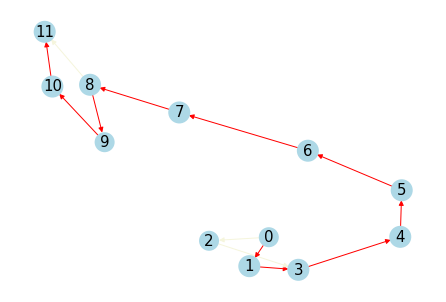

W: 301.0


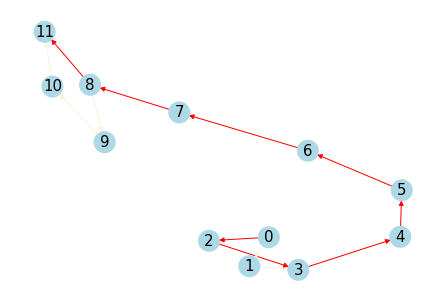


Iteration 1


Model: Flow Decomposition
 - number of variables: 7
   - binary=3, integer=4, continuous=0
 - number of constraints: 16
   - linear=16
 - parameters:
     parameters.threads = 8
     parameters.timelimit = 60.00000000000000
     parameters.mip.display = 0
 - objective: none
 - problem type is: MILP
status integer infeasible

Iteration 2


Model: Flow Decomposition
 - number of variables: 14
   - binary=6, integer=8, continuous=0
 - number of constraints: 29
   - linear=29
 - parameters:
     parameters.threads = 8
     parameters.timelimit = 60.00000000000000
     parameters.mip.display = 0
 - objective: none
 - problem type is: MILP
status integer infeasible


TypeError: object of type 'int' has no len()

In [9]:
path = "./data/rnaseq/tests/"
text_files = [f for f in os.listdir(path) if f.endswith('.graph')]

for i in range(0,1):    
    filename = text_files[i]
    outfileName = "".join([filename.split(".")[0],"_test_results.txt"])
    data = inputs(''.join([path,filename]),''.join([path,filename.split(".")[0]]))
    data = SolveInstances(data)
    outputFiles(data,outfileName)
    print(data)
print("Done")